#### Monday, March 18, 2024

mamba activate t4nlpacv-2

This environment has TensorFlow, so let's try running all of this notebook, shall we ... 

Nice! This notebook can run the TensorFlow code! Except for the very last cell, this notebook now runs in one pass.

#### Monday, March 11, 2024

I did not run the cells that utilize TensorFlow because I do not have or want to install it to this conda environment. 

In [1]:
# only target the 4090 ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Transformers are hardware-driven Architectures

copyright 2023, Denis Rothman

Transformers are hardware and data-driven architectures. This notebooks illustrates the hardware-driven perspective.

This notebook illlustrates the complexity for Self-attention and reccurent layers. The functions are not the actual algorithms of Transformers and RNNs. They simply show how the complexity of the layers varies with a CPU, a GPU, and a TPU. **Run the notebook cell by cell to make sure to choose the right type of processor. If you don't have access to a GPU or a TPU, you can read the notebook.**

Self-attention layers benefit from matrix multiplications whereas reccurent layers are mostly sequential.

The notebook is divided into 3 sections: CPU, GPU, and TPU.

Reference for complexity: [Attention is All You Need, Vaswani et al.(2017)](https://arxiv.org/abs/1706.03762), page 6:

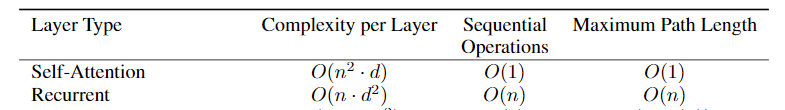





# CPU

In [2]:
#Computational times of complexity per layer
# Comparing the computational time between:
# self attention = O(n^2 * d)
#and
# recurrent = O(n * d^2)
import numpy as np
import time

# define the sequence length and representation dimensionality
n = 512
d = 512

# define the inputs
input_seq = np.random.rand(n, d)

In [3]:
# simulation of self-attention layer O(n^2*d)
start_time = time.time()
for i in range(n):
    for j in range(n):
        _ = np.dot(input_seq[i], input_seq[j])
at=time.time()-start_time
print(f"Self-attention computation time: {time.time() - start_time} seconds")

Self-attention computation time: 0.25295257568359375 seconds


In [4]:
# This puts a 100% load on single CPU core.
# simulation of recurrent layer O(n*d^2)
start_time = time.time()
hidden_state = np.zeros(d)
for i in range(n):
    for j in range(d):
        for k in range(d):
            hidden_state[j] += input_seq[i, j] * hidden_state[k]
rt=time.time()-start_time
print(f"Recurrent layer computation time: {time.time() - start_time} seconds")

# 50.8s

Recurrent layer computation time: 50.12848377227783 seconds


In [5]:
# Calculate the total
total = at + rt

# Calculate the percentage of at
percentage_at = round((at / total) * 100,2)

# Output the result
print(f"The percentage of 'computational time for attention' in the sum of 'attention' and 'recurrent' is {percentage_at}%")

# Calculate x, which is the ratio of rt to at
x = round(rt / at,2)

The percentage of 'computational time for attention' in the sum of 'attention' and 'recurrent' is 0.5%


## Output
   
Self-attention computation time: 0.7938594818115234 seconds  
Recurrent layer computation time: 109.65185356140137 seconds  
The percentage of 'computational time for attention' in the sum of 'attention' and 'recurrent' is 0.72%

**Note:** the processors may evolve but the concepts remains the same.

# GPU

In [6]:
# PyTorch version
import torch
import time

# define the sequence length and representation dimensionality
n = 512
d = 512

# Use GPU if available, otherwise stick with cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
# Running this takes 388 MiB VRAM on the 4090
# define the inputs
input_seq = torch.rand(n, d, device=device)

In [8]:
# Running this bumps 4090 VRAM usage to 418 MiB
# simulation of self-attention layer O(n^2*d)
start_time = time.time()
_ = torch.mm(input_seq, input_seq.t())
at = time.time() - start_time
print(f"Self-attention computation time: {at} seconds")

Self-attention computation time: 0.014254093170166016 seconds


In [9]:
# This puts about a 15% load on the 4090 ... 480 MiB VRAM
# simulation of recurrent layer O(n*d^2)
start_time = time.time()
hidden_state = torch.zeros(d, device=device)
for i in range(n):
    for j in range(d):
        for k in range(d):
            hidden_state[j] += input_seq[i, j] * hidden_state[k]
            ct = time.time() - start_time
            if ct>at*10:
              break

# 6.6s

In [10]:
rt = time.time() - start_time
print(f"Recurrent layer computation time: {rt} seconds")

# Calculate the total
total = at + rt

# Calculate the percentage of at
percentage_at = round((at / total) * 100, 2)

# Output the result
print(f"The percentage of self-attention computation in the sum of self-attention and recurrent computation is {percentage_at}%")

Recurrent layer computation time: 6.482875823974609 seconds
The percentage of self-attention computation in the sum of self-attention and recurrent computation is 0.22%


## Output    
cuda
Self-attention computation time: 2.887202501296997 seconds
Recurrent layer computation time: 36.3216814994812 seconds
The percentage of self-attention computation in the sum of self-attention and recurrent computation is 7.36%

**Note:**: the processors may evolve but the concepts remains the same.

In [11]:
!nvidia-smi

Mon Mar 18 15:25:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P0              N/A /  70W |    446MiB /  2048MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Output for processor information

**Note:**: the processors may evolve but the concepts remains the same

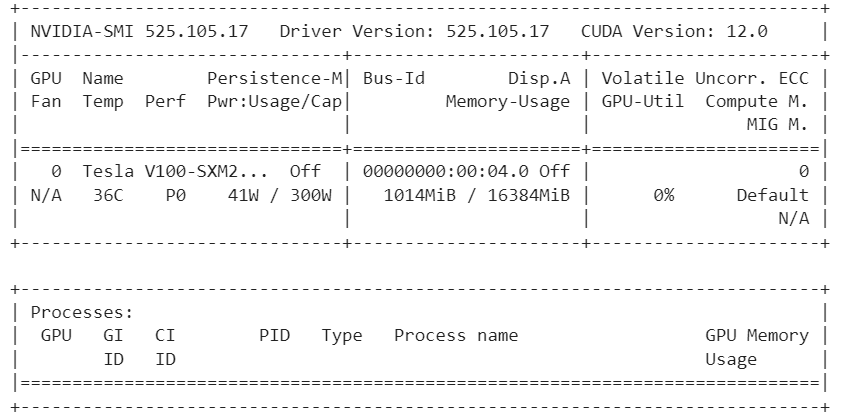

# TPU

In [12]:
import tensorflow as tf
import numpy as np
import time

2024-03-18 15:25:33.754393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 15:25:34.517469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
# define the sequence length and representation dimensionality
n = 512
d = 512

In [14]:
# Running this bumps 4090 VRAM usage from 480 Mib to 22662 MiB
# define the inputs
input_seq = tf.random.normal((n, d), dtype=tf.float32)

2024-03-18 15:25:35.451211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 15:25:35.481747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 15:25:35.481906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
# 22670 MiB
# simulation of self-attention layer O(n^2*d)
start_time = time.time()
_ = tf.matmul(input_seq, input_seq, transpose_b=True)
at = time.time() - start_time
print(f"Self-attention computation time: {at} seconds")

Self-attention computation time: 0.028386831283569336 seconds


In [16]:
# Running this puts a load on all 8 CPU Cores ... bouncing around 30% usage ... the 4090 does not show any load.
# simulation of recurrent layer O(n*d^2)
start_time = time.time()
hidden_state = np.zeros((n, d), dtype=np.float32)
for i in range(n):
    for j in range(d):
        for k in range(d):
            hidden_state[i, j] += input_seq[i, j].numpy() * hidden_state[min(i,k), j]
            ct = time.time() - start_time
            if ct>at*10:
              break

# 1m 16.1s
# 22670 MiB VRAM

In [17]:
rt = time.time() - start_time
print(f"Recurrent layer computation time: {rt} seconds")

# Calculate the total
total = at + rt

# Calculate the percentage of at
percentage_at = round((at / total) * 100, 2)

# Output the result
print(f"The percentage of self-attention computation in the sum of self-attention and recurrent computation is {percentage_at}%")

Recurrent layer computation time: 76.70818614959717 seconds
The percentage of self-attention computation in the sum of self-attention and recurrent computation is 0.04%


## Output
Self-attention computation time: 0.10626077651977539 seconds  
Recurrent layer computation time: 66.53181290626526 seconds  
The percentage of self-attention computation in the sum of self-attention and recurrent computation is 0.16%'  
**Note:**
 The processors may evolve but the concepts remains the same.

## LLM configuration

In [18]:
import tensorflow as tf
import numpy as np
import time

# define the sequence length and representation dimensionality
n =  32768
d = 12288

In [19]:
# define the inputs
input_seq = tf.random.normal((n, d), dtype=tf.float32)

# simulation of self-attention layer O(n^2*d)
start_time = time.time()
_ = tf.matmul(input_seq, input_seq, transpose_b=True)

at = time.time() - start_time
print(f"Self-attention computation time: {at} seconds")

Self-attention computation time: 0.0003249645233154297 seconds


### Output LLM configuration

Self-attention computation time: 23.391557216644287 seconds

**Note:**   
The processors may evolve but the concepts remains the same.

### TPU information

Restart the runtime before running this cell.


In [20]:
import os
from tensorflow.python.profiler import profiler_client

In [21]:
# This cell will fail to run cuz we are local ... so let's just disable it ...
# tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
# print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

**Output:**  
  Timestamp: 07:49:22  
  TPU type: TPU v2  
  Utilization of TPU Matrix Units (higher is better): 0.000%


I added this code to the end of the notebook just to show a graph of the logit function. This code was generated by ChatGPT.

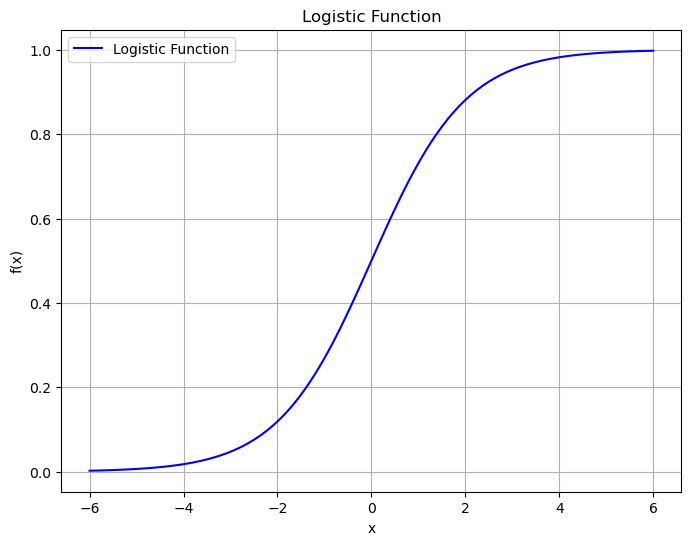

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Generate x values
x = np.linspace(-6, 6, 100)

# Calculate y values using the logistic function
y = logistic(x)

# Plot the logistic function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Logistic Function', color='blue')
plt.title('Logistic Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.show()
